<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/%EA%B7%9C%EC%88%9C/%20TranAD/%20TranAD_3%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#드리아브 마운트 및 필수 라이브러리 로드
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from tqdm import tqdm

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==========================================
# 1. 라이브러리 임포트 및 설정
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score
import os
import math

# CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. 데이터 로드
# ==========================================
# 업로드된 파일명 사용 (환경에 맞게 경로 수정 가능)
file_path = ("/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx")

if os.path.exists(file_path):
    print(f"Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
else:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 임시 빈 데이터프레임 생성 (에러 방지용)
    df = pd.DataFrame()

# 센서 컬럼 정의
sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

# ==========================================
# 3. 데이터 전처리 함수
# ==========================================
"""
    Wafer_ID 별로 그룹화하여 슬라이딩 윈도우를 적용하는 함수

    Args:
        df_target: 대상 데이터프레임
        wafer_col: Wafer ID 컬럼명
        sensor_cols: 센서 데이터 컬럼 리스트
        seq_len: 윈도우 크기
        scaler: 사용할 스케일러 (None이면 새로 생성)
        is_train: 학습 모드 여부 (True면 fit_transform, False면 transform)

    Returns:
        X_all: (N, seq_len, n_features) 형태의 numpy 배열
        scaler: 학습/사용된 스케일러
"""
def create_sequences_per_wafer(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):

    # 1. 스케일링 처리
    # (Wafer별로 따로 스케일링하면 Wafer 간의 상대적 크기 정보가 사라질 수 있으므로 전체 기준으로 합니다.)
    data_values = df_target[sensor_cols].values

    if is_train:
        # 학습용: Scaler 생성 및 학습
        if scaler is None:
            scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        # 테스트용: 기존 Scaler 사용
        if scaler is None:
            raise ValueError("Test mode requires a fitted scaler.")
        data_scaled = scaler.transform(data_values)

    # 스케일링 된 데이터를 다시 DataFrame에 맵핑 (Wafer ID로 그룹핑하기 위해)
    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col]

    all_sequences = []

    # 2. Wafer ID 별로 슬라이딩 윈도우 적용
    unique_wafers = df_scaled[wafer_col].unique()

    for wafer in unique_wafers:
        # 특정 Wafer 데이터 추출
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values

        # 데이터가 윈도우 크기보다 작으면 스킵
        if len(wafer_data) < seq_len:
            continue

        # 슬라이딩 윈도우 생성
        for i in range(len(wafer_data) - seq_len + 1):
            all_sequences.append(wafer_data[i : i + seq_len])

    if len(all_sequences) == 0:
        return np.array([]), scaler

    return np.array(all_sequences), scaler

# ==========================================
# 4. 데이터셋 구성 (실험별 루프)
# ==========================================
experiments = ['l29', 'l31', 'l33']
datasets = {}

print("\n--- Preprocessing Data (Per Wafer Logic) ---")

for exp_id in experiments:
    print(f"\nProcessing Experiment: {exp_id}")

    # 1. 해당 실험 데이터 추출
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]

    if exp_df.empty:
        print(f"No data for {exp_id}")
        continue

    # 2. Wafer ID 추출 및 분할 (Label 기준)
    # 정상 Wafer와 불량 Wafer의 ID 리스트를 확보
    normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
    fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

    print(f"  - Total Normal Wafers: {len(normal_wafer_ids)}")
    print(f"  - Total Fault Wafers: {len(fault_wafer_ids)}")

    # 정상 Wafer가 너무 적으면 스킵
    if len(normal_wafer_ids) < 4:
        print("  - Not enough normal wafers to split.")
        continue

    # 3. Train / Test Split (Wafer ID 기준)
    # 정상 Wafer 중 80%는 학습용, 20%는 테스트용
    n_train_wafers = int(len(normal_wafer_ids) * 0.8)

    train_wafer_ids = normal_wafer_ids[:n_train_wafers]
    test_norm_wafer_ids = normal_wafer_ids[n_train_wafers:]

    # ID를 기준으로 데이터프레임 필터링
    train_df = exp_df[exp_df['Wafer_ID'].isin(train_wafer_ids)]
    test_norm_df = exp_df[exp_df['Wafer_ID'].isin(test_norm_wafer_ids)]
    test_fault_df = exp_df[exp_df['Wafer_ID'].isin(fault_wafer_ids)]

    # 4. 슬라이딩 윈도우 파라미터 설정
    SEQ_LEN = 10

    # (1) Train Data: Fit & Transform
    # 여기서 만들어진 scaler를 반환받아 테스트셋에 적용합니다.
    X_train, scaler = create_sequences_per_wafer(
        train_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True
    )

    # (2) Test Normal Data: Transform Only
    X_test_normal, _ = create_sequences_per_wafer(
        test_norm_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False     # 학습 데이터로 변환한 Scaler 적용
    )

    # (3) Test Fault Data: Transform Only
    if not test_fault_df.empty:
        X_test_fault, _ = create_sequences_per_wafer(
            test_fault_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False    # 학습 데이터로 변환한 Scaler 적용
        )
    else:
        X_test_fault = np.array([])

    # 5. 결과 저장
    datasets[exp_id] = {
        'X_train': X_train,
        'X_test_norm': X_test_normal,
        'X_test_fault': X_test_fault,
        'scaler': scaler
    }

    print(f"  -> [{exp_id}] Result Shapes:")
    print(f"     X_train     : {X_train.shape}")
    print(f"     X_test_norm : {X_test_normal.shape}")
    print(f"     X_test_fault: {X_test_fault.shape}")

print("\nData preprocessing completed.")


Loading data from: /content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx

--- Preprocessing Data (Per Wafer Logic) ---

Processing Experiment: l29
  - Total Normal Wafers: 34
  - Total Fault Wafers: 9
  -> [l29] Result Shapes:
     X_train     : (2546, 10, 19)
     X_test_norm : (634, 10, 19)
     X_test_fault: (832, 10, 19)

Processing Experiment: l31
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l31] Result Shapes:
     X_train     : (2589, 10, 19)
     X_test_norm : (722, 10, 19)
     X_test_fault: (488, 10, 19)

Processing Experiment: l33
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l33] Result Shapes:
     X_train     : (2607, 10, 19)
     X_test_norm : (706, 10, 19)
     X_test_fault: (550, 10, 19)

Data preprocessing completed.


In [ ]:
# 전처리 검토
def inspect_sliding_window_logic(df, experiment_id, wafer_idx=0, seq_len=10):
    print(f"=== Sliding Window Verification for Experiment: {experiment_id} ===")

    # 1. 해당 실험의 특정 Wafer ID 하나 선택
    exp_df = df[df['Wafer_ID'].str.contains(experiment_id, case=False, na=False)]
    unique_wafers = exp_df['Wafer_ID'].unique()

    if len(unique_wafers) == 0:
        print("해당 실험 데이터가 없습니다.")
        return

    target_wafer = unique_wafers[wafer_idx] # 첫 번째 Wafer 선택
    print(f"Target Wafer ID: {target_wafer}")

    # 2. 원본 데이터(Raw) 추출
    # 전처리 때 사용한 센서 컬럼만 선택
    raw_data = exp_df[exp_df['Wafer_ID'] == target_wafer][sensor_cols].values
    raw_len = len(raw_data)

    print(f"Original Data Length (Rows): {raw_len}")
    print(f"Window Size (Seq_len): {seq_len}")

    # 3. 이론상 생성되어야 할 시퀀스 개수 계산
    # 공식: (원본 길이 - 윈도우 크기) + 1
    expected_sequences = raw_len - seq_len + 1
    print(f"Expected Sequences: {raw_len} - {seq_len} + 1 = {expected_sequences}")

    # 4. 실제 슬라이딩 윈도우 수행 (검증용 로직)
    actual_sequences = []
    for i in range(expected_sequences):
        actual_sequences.append(raw_data[i : i + seq_len])

    actual_sequences = np.array(actual_sequences)
    print(f"Generated Sequences Shape: {actual_sequences.shape}")

    if expected_sequences == actual_sequences.shape[0]:
        print(">> [PASS] 시퀀스 개수가 이론과 정확히 일치합니다.")
    else:
        print(">> [FAIL] 시퀀스 개수가 다릅니다!")

    print("\n--- Data Content Check (First 2 Sequences) ---")
    # 5. 데이터가 한 칸씩 밀렸는지 확인 (첫 번째 센서 기준)
    # 첫 번째 시퀀스 (Time 0 ~ 9)
    seq_0 = actual_sequences[0, :, 0] # 첫 번째 시퀀스의 첫 번째 센서 값들
    # 두 번째 시퀀스 (Time 1 ~ 10)
    seq_1 = actual_sequences[1, :, 0] # 두 번째 시퀀스의 첫 번째 센서 값들

    print(f"Seq 0 (Time 0~9) : {seq_0}")
    print(f"Seq 1 (Time 1~10): {seq_1}")

    # 비교: Seq 1의 앞부분(0~8)이 Seq 0의 뒷부분(1~9)과 같아야 함
    is_shifted_correctly = np.allclose(seq_0[1:], seq_1[:-1])

    print(f"\nVerifying Overlap (Seq 0[1:] == Seq 1[:-1]): {is_shifted_correctly}")
    if is_shifted_correctly:
        print(">> [PASS] 데이터가 정확히 1 Time Step씩 슬라이딩 되었습니다.")
    else:
        print(">> [FAIL] 데이터 슬라이딩이 올바르지 않습니다.")

# 검증 실행 (l29 실험의 첫 번째 Wafer 확인)
inspect_sliding_window_logic(df, 'l29', wafer_idx=0, seq_len=10)


=== Sliding Window Verification for Experiment: l29 ===
Target Wafer ID: l2901.txm
Original Data Length (Rows): 112
Window Size (Seq_len): 10
Expected Sequences: 112 - 10 + 1 = 103
Generated Sequences Shape: (103, 10, 19)
>> [PASS] 시퀀스 개수가 이론과 정확히 일치합니다.

--- Data Content Check (First 2 Sequences) ---
Seq 0 (Time 0~9) : [751. 751. 751. 751. 751. 751. 751. 751. 751. 751.]
Seq 1 (Time 1~10): [751. 751. 751. 751. 751. 751. 751. 751. 751. 751.]

Verifying Overlap (Seq 0[1:] == Seq 1[:-1]): True
>> [PASS] 데이터가 정확히 1 Time Step씩 슬라이딩 되었습니다.


In [ ]:
import numpy as np

def verify_sliding_window_random(df, experiment_id, wafer_idx=0, seq_len=10):
    print(f"=== Random Sliding Window Verification for {experiment_id} ===")

    # 1. 데이터 준비 (이전과 동일)
    exp_df = df[df['Wafer_ID'].str.contains(experiment_id, case=False, na=False)]
    unique_wafers = exp_df['Wafer_ID'].unique()

    if len(unique_wafers) == 0:
        print("데이터 없음")
        return

    target_wafer = unique_wafers[wafer_idx]
    # 원본 데이터 (numpy array)
    raw_data = exp_df[exp_df['Wafer_ID'] == target_wafer][sensor_cols].values

    # 2. 슬라이딩 윈도우 생성
    sequences = []
    for i in range(len(raw_data) - seq_len + 1):
        sequences.append(raw_data[i : i + seq_len])
    sequences = np.array(sequences)

    total_seq = sequences.shape[0]
    print(f"Target Wafer: {target_wafer}")
    print(f"Total Generated Sequences: {total_seq}")

    # 3. 무작위 인덱스 선택 (마지막 인덱스는 다음 게 없으므로 제외)
    # 값이 변하는 것을 보기 위해 시도 횟수를 늘리거나 하지 않고, 순수 랜덤으로 뽑습니다.
    rand_idx = np.random.randint(0, total_seq - 1)

    print(f"\n--- Checking Random Index: {rand_idx} vs {rand_idx+1} ---")

    # 두 개의 연속된 시퀀스 추출
    seq_A = sequences[rand_idx]      # 현재 시퀀스
    seq_B = sequences[rand_idx + 1]  # 다음 시퀀스 (1 Time step 뒤)

    # 4. 비교를 위해 특정 센서 하나만 출력 (값이 좀 변하는 센서를 찾아서 출력하면 좋음)
    # 여기서는 6번째 센서(Pressure)나 10번째(RF Pwr) 등을 봅니다.
    target_sensor_idx = 6  # Pressure (예시)
    sensor_name = sensor_cols[target_sensor_idx]

    val_A = seq_A[:, target_sensor_idx]
    val_B = seq_B[:, target_sensor_idx]

    print(f"Sensor: {sensor_name}")
    print(f"Seq {rand_idx:<3} (t={rand_idx}~{rand_idx+9})   : {np.round(val_A, 2)}")
    print(f"Seq {rand_idx+1:<3} (t={rand_idx+1}~{rand_idx+10}): {np.round(val_B, 2)}")

    # 5. 시각적 검증 가이드
    print("\n[검증 가이드]")
    print(f"Seq {rand_idx}의 2번째 값({val_A[1]:.2f})부터 마지막 값까지가")
    print(f"Seq {rand_idx+1}의 1번째 값({val_B[0]:.2f})부터 9번째 값과 같아야 합니다.")

    # 6. 로직 검증
    # seq_A[1:] 과 seq_B[:-1] 이 같은지 확인
    is_match = np.allclose(seq_A[1:], seq_B[:-1])

    print(f"\n>> Overlap Check Result: {is_match}")
    if is_match:
        print(">> [SUCCESS] 데이터가 정확하게 한 칸씩 밀려있습니다.")
    else:
        print(">> [FAIL] 데이터 불일치 발생!")

# 실행
verify_sliding_window_random(df, 'l29', wafer_idx=0, seq_len=10)

=== Random Sliding Window Verification for l29 ===
Target Wafer: l2901.txm
Total Generated Sequences: 103

--- Checking Random Index: 1 vs 2 ---
Sensor: Pressure
Seq 1   (t=1~10)   : [1229. 1221. 1201. 1182. 1144. 1171. 1194. 1198. 1194. 1171.]
Seq 2   (t=2~11): [1221. 1201. 1182. 1144. 1171. 1194. 1198. 1194. 1171. 1192.]

[검증 가이드]
Seq 1의 2번째 값(1221.00)부터 마지막 값까지가
Seq 2의 1번째 값(1221.00)부터 9번째 값과 같아야 합니다.

>> Overlap Check Result: True
>> [SUCCESS] 데이터가 정확하게 한 칸씩 밀려있습니다.


In [ ]:
def verify_wafer_aggregation(df, datasets, experiments, seq_len=10):
    print("="*60)
    print("      데이터셋 구성 무결성 검증 (Wafer Aggregation Check)")
    print("="*60)

    for exp_id in experiments:
        print(f"\nTarget Experiment: [{exp_id}]")

        # 1. 원본 데이터에서 Wafer ID 리스트 및 분할 로직 재현
        exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]
        if exp_df.empty: continue

        # Normal / Fault 분류
        normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
        fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

        # Train / Test Split (80:20) 로직 재현
        n_train = int(len(normal_wafer_ids) * 0.8)
        train_ids = normal_wafer_ids[:n_train]
        test_norm_ids = normal_wafer_ids[n_train:]
        test_fault_ids = fault_wafer_ids # 전체 사용

        # 검증 대상 맵핑
        targets = [
            ('X_train', train_ids),
            ('X_test_norm', test_norm_ids),
            ('X_test_fault', test_fault_ids)
        ]

        for key, wafer_ids in targets:
            # 저장된 실제 데이터 모양
            stored_data = datasets[exp_id][key]
            actual_count = stored_data.shape[0] if len(stored_data) > 0 else 0

            # 2. Wafer ID 별 기대 시퀀스 개수 계산
            expected_count = 0
            wafer_details = [] # 상세 로그용

            for wafer in wafer_ids:
                # 해당 Wafer의 원본 데이터 길이
                raw_len = len(exp_df[exp_df['Wafer_ID'] == wafer])

                # 시퀀스 생성 가능 개수 계산
                if raw_len >= seq_len:
                    seq_count = raw_len - seq_len + 1
                    expected_count += seq_count
                    wafer_details.append(f"{wafer}({seq_count})")
                else:
                    wafer_details.append(f"{wafer}(Skip:TooShort)")

            # 3. 비교 및 결과 출력
            print(f"  [{key}] Check:")
            print(f"    - Included Wafers ({len(wafer_ids)}): {', '.join(wafer_details[:5])} ...") # 5개만 예시 출력
            print(f"    - Expected Sum : {expected_count}")
            print(f"    - Actual Shape : {actual_count}")

            if expected_count == actual_count:
                print(f"    >> [PASS] {key} 데이터가 누락 없이 정확하게 합쳐졌습니다.")
            else:
                print(f"    >> [FAIL] 개수 불일치! (Diff: {actual_count - expected_count})")

    print("\nVerification Completed.")

# 검증 실행
verify_wafer_aggregation(df, datasets, experiments, seq_len=10)

      데이터셋 구성 무결성 검증 (Wafer Aggregation Check)

Target Experiment: [l29]
  [X_train] Check:
    - Included Wafers (27): l2901.txm(103), l2902.txm(98), l2903.txm(97), l2904.txm(95), l2905.txm(96) ...
    - Expected Sum : 2546
    - Actual Shape : 2546
    >> [PASS] X_train 데이터가 누락 없이 정확하게 합쳐졌습니다.
  [X_test_norm] Check:
    - Included Wafers (7): l2932.txm(91), l2933.txm(91), l2934.txm(93), l2935.txm(92), l2941.txm(89) ...
    - Expected Sum : 634
    - Actual Shape : 634
    >> [PASS] X_test_norm 데이터가 누락 없이 정확하게 합쳐졌습니다.
  [X_test_fault] Check:
    - Included Wafers (9): l2915.txm(94), l2916.txm(97), l2917.txm(93), l2918.txm(84), l2936.txm(89) ...
    - Expected Sum : 832
    - Actual Shape : 832
    >> [PASS] X_test_fault 데이터가 누락 없이 정확하게 합쳐졌습니다.

Target Experiment: [l31]
  [X_train] Check:
    - Included Wafers (29): l3101.txm(99), l3102.txm(96), l3103.txm(97), l3104.txm(94), l3105.txm(95) ...
    - Expected Sum : 2589
    - Actual Shape : 2589
    >> [PASS] X_train 데이터가 누락 없이 정확하게 합쳐졌습

Using Device: cpu

[l29] Model Training & Evaluation Start


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Training Start... (Total Epochs: 30)
Epoch [1/30], Loss: 0.049114
Epoch [5/30], Loss: 0.016432
Epoch [10/30], Loss: 0.009573
Epoch [15/30], Loss: 0.006928
Epoch [20/30], Loss: 0.005295
Epoch [25/30], Loss: 0.004316
Epoch [30/30], Loss: 0.003587
  -> AUC: 0.7831
  -> F1-Score: 0.6559
  -> Accuracy: 0.6937
  -> Best Threshold: 0.004629
  -> Confusion Matrix:
[[589  45]
 [404 428]]

[l31] Model Training & Evaluation Start
Training Start... (Total Epochs: 30)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/30], Loss: 0.054309
Epoch [5/30], Loss: 0.020313
Epoch [10/30], Loss: 0.011995
Epoch [15/30], Loss: 0.008842
Epoch [20/30], Loss: 0.007050
Epoch [25/30], Loss: 0.005938
Epoch [30/30], Loss: 0.005136
  -> AUC: 0.7958
  -> F1-Score: 0.6868
  -> Accuracy: 0.7860
  -> Best Threshold: 0.006391
  -> Confusion Matrix:
[[667  55]
 [204 284]]

[l33] Model Training & Evaluation Start
Training Start... (Total Epochs: 30)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch [1/30], Loss: 0.048912
Epoch [5/30], Loss: 0.016793
Epoch [10/30], Loss: 0.009699
Epoch [15/30], Loss: 0.007143
Epoch [20/30], Loss: 0.005585
Epoch [25/30], Loss: 0.004582
Epoch [30/30], Loss: 0.003912
  -> AUC: 0.8544
  -> F1-Score: 0.7696
  -> Accuracy: 0.7946
  -> Best Threshold: 0.003456
  -> Confusion Matrix:
[[567 139]
 [119 431]]


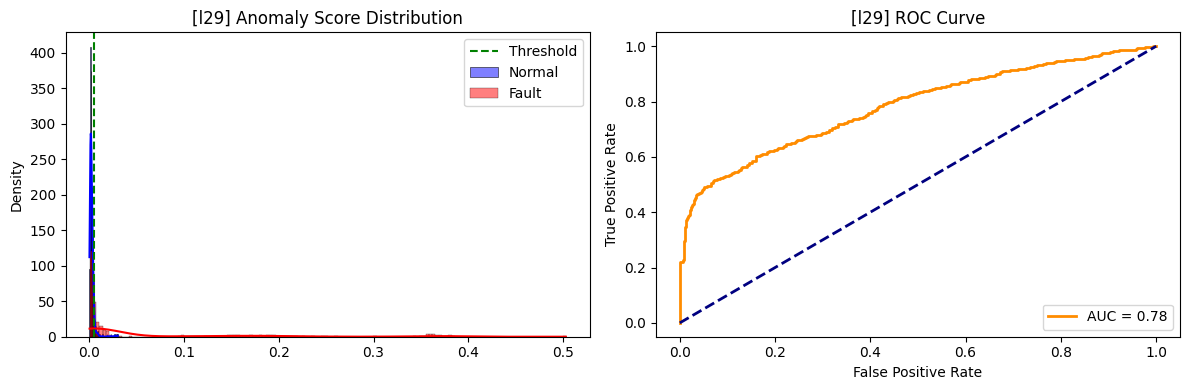

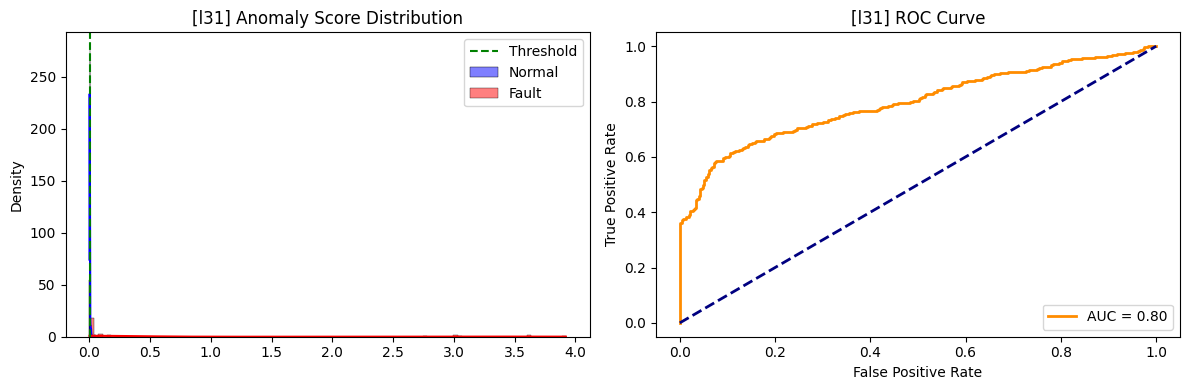

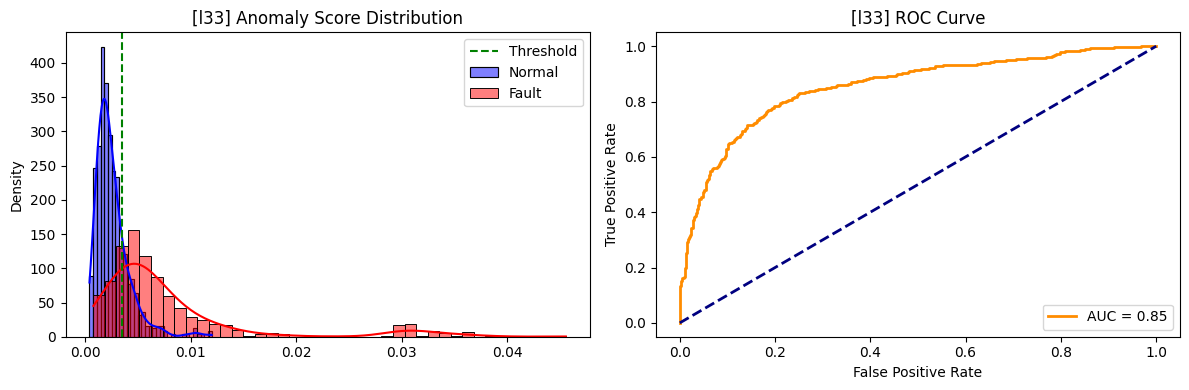

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score

# ==========================================
# 1. TranAD 모델 정의 (논문 구조 유지)
# ==========================================
class TranAD(nn.Module):
    def __init__(self, n_feats, sequence_len):
        super(TranAD, self).__init__()
        self.name = 'TranAD'
        self.n_feats = n_feats
        self.n_window = sequence_len
        self.batch_size = 128

        # Transformer 인코더/디코더 레이어 (논문 기본값)
        self.transformer = nn.Transformer(
            d_model=n_feats,
            nhead=1,            # 센서 수가 적으면 head 수를 줄이는 것이 안정적일 수 있음 (원본은 n_feats)
            num_encoder_layers=1,
            num_decoder_layers=1,
            dim_feedforward=64,
            dropout=0.1,
            batch_first=True    # 중요: (Batch, Seq, Feat) 형태 유지를 위해 True 설정
        )

        # 위치 인코딩 (Positional Encoding) - 학습 가능한 형태로 구현
        self.pos_encoder = nn.Parameter(torch.randn(1, self.n_window, n_feats))

        # 최종 출력 레이어 (Sigmoid로 0~1 사이 값 출력)
        self.fcn = nn.Sequential(nn.Linear(n_feats, n_feats), nn.Sigmoid())

    def forward(self, src, tgt):
        # src: (Batch, Window_Size, Feats)
        # tgt: (Batch, 1, Feats) -> 디코더 입력 (보통 윈도우의 마지막 값)

        # Positional Encoding 더하기
        src = src + self.pos_encoder[:, :src.shape[1], :]

        # Transformer 통과
        out = self.transformer(src, tgt)

        # 최종 출력
        return self.fcn(out)

# ==========================================
# 2. 학습 함수 (작성하신 데이터셋 구조에 맞춤)
# ==========================================
def train_tranad(model, X_train_np, num_epochs=10, learning_rate=0.001, device='cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Numpy -> Tensor 변환 및 DataLoader 생성
    tensor_x = torch.Tensor(X_train_np)
    # TranAD는 Unsupervised이므로 입력이 곧 타겟입니다. (Reconstruction)
    dataloader = DataLoader(TensorDataset(tensor_x), batch_size=model.batch_size, shuffle=True)

    model.train()
    print(f"Training Start... (Total Epochs: {num_epochs})")

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in dataloader:
            # batch[0] shape: (Batch_Size, Seq_Len, Feats)
            x = batch[0].to(device)

            # TranAD 입력 구조 분리
            # src: 전체 윈도우
            # tgt: 윈도우의 마지막 시점 데이터 (Focus) -> (Batch, 1, Feats)로 차원 유지
            src = x
            tgt = x[:, -1, :].unsqueeze(1)

            optimizer.zero_grad()

            # Forward
            output = model(src, tgt)

            # Loss Calculation (재구성 오차: 출력값 vs 실제 마지막 값)
            # output shape: (Batch, 1, Feats), tgt shape: (Batch, 1, Feats)
            loss = criterion(output, tgt)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.6f}")

    return model

# ==========================================
# 3. 추론 및 평가 함수 (Norm/Fault 분리된 구조 통합)
# ==========================================
def evaluate_tranad(model, X_test_norm, X_test_fault, device='cpu'):
    model.eval()
    criterion = nn.MSELoss(reduction='none') # 샘플별 오차를 구하기 위해 reduction='none'

    def get_anomaly_scores(data_np):
        if len(data_np) == 0: return np.array([])

        dataset = TensorDataset(torch.Tensor(data_np))
        loader = DataLoader(dataset, batch_size=128, shuffle=False)
        scores = []

        with torch.no_grad():
            for batch in loader:
                x = batch[0].to(device)
                src = x
                tgt = x[:, -1, :].unsqueeze(1)

                output = model(src, tgt)

                # Anomaly Score: MSE (Mean Squared Error per sample)
                # (Batch, 1, Feats) -> Feats 차원 평균 -> (Batch, 1) -> (Batch)
                loss = torch.mean((output - tgt) ** 2, dim=2).squeeze()

                if loss.ndim == 0: # 배치가 1개일 경우 스칼라가 되므로 리스트화
                    scores.append(loss.item())
                else:
                    scores.extend(loss.cpu().numpy())
        return np.array(scores)

    # 1. 정상 및 불량 데이터에 대한 Anomaly Score 산출
    scores_norm = get_anomaly_scores(X_test_norm)
    scores_fault = get_anomaly_scores(X_test_fault)

    # 2. 결과 통합 (Labeling: Normal=0, Fault=1)
    if len(scores_fault) == 0:
        print("경고: 불량 데이터가 없습니다. ROC/AUC를 계산할 수 없습니다.")
        return None

    y_scores = np.concatenate([scores_norm, scores_fault])
    y_true = np.concatenate([np.zeros(len(scores_norm)), np.ones(len(scores_fault))])

    # 3. ROC Curve 및 AUC 계산
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # 4. 최적 Threshold 찾기 (Youden's Index: J = tpr - fpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # 5. 최종 예측 및 성능 지표
    y_pred = (y_scores > optimal_threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred)

    return {
        'auc': roc_auc,
        'accuracy': acc,
        'f1_score': f1,
        'confusion_matrix': conf_mat,
        'threshold': optimal_threshold,
        'scores_norm': scores_norm,
        'scores_fault': scores_fault
    }

# ==========================================
# 4. 전체 실행 루프 (실험 ID 별)
# ==========================================
# 위에서 작성하신 전처리 코드가 실행되어 'datasets' 딕셔너리가 존재한다고 가정합니다.
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

results = {}

for exp_id in experiments:
    print(f"\n[{exp_id}] Model Training & Evaluation Start")

    data = datasets[exp_id]
    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    X_test_fault = data['X_test_fault']

    # 데이터 차원 확인
    # X_train shape: (Samples, Seq_Len, Feats)
    n_samples, seq_len, n_feats = X_train.shape

    # 모델 초기화
    model = TranAD(n_feats=n_feats, sequence_len=seq_len)

    # 학습
    model = train_tranad(model, X_train, num_epochs=30, learning_rate=0.001, device=device)

    # 평가
    eval_metrics = evaluate_tranad(model, X_test_norm, X_test_fault, device=device)

    if eval_metrics:
        results[exp_id] = eval_metrics
        print(f"  -> AUC: {eval_metrics['auc']:.4f}")
        print(f"  -> F1-Score: {eval_metrics['f1_score']:.4f}")
        print(f"  -> Accuracy: {eval_metrics['accuracy']:.4f}")
        print(f"  -> Best Threshold: {eval_metrics['threshold']:.6f}")
        print(f"  -> Confusion Matrix:\n{eval_metrics['confusion_matrix']}")

# ==========================================
# 5. 결과 시각화
# ==========================================
for exp_id, metrics in results.items():
    plt.figure(figsize=(12, 4))

    # Anomaly Score 분포
    plt.subplot(1, 2, 1)
    sns.histplot(metrics['scores_norm'], color='blue', label='Normal', kde=True, stat="density", common_norm=False)
    sns.histplot(metrics['scores_fault'], color='red', label='Fault', kde=True, stat="density", common_norm=False)
    plt.axvline(metrics['threshold'], color='green', linestyle='--', label='Threshold')
    plt.title(f'[{exp_id}] Anomaly Score Distribution')
    plt.legend()

    # ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(
        np.concatenate([np.zeros(len(metrics['scores_norm'])), np.ones(len(metrics['scores_fault']))]),
        np.concatenate([metrics['scores_norm'], metrics['scores_fault']])
    )
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {metrics["auc"]:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'[{exp_id}] ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

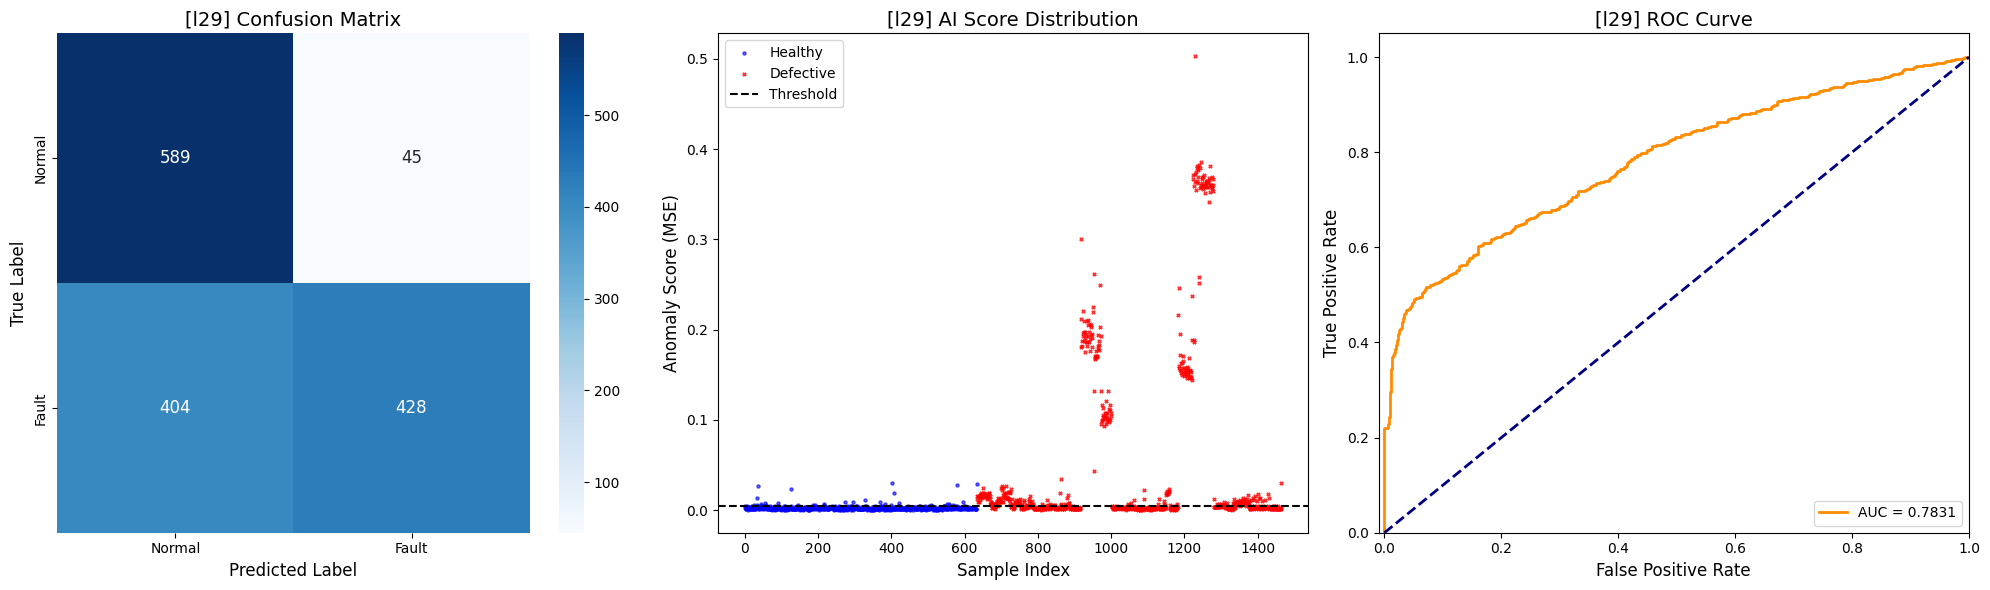

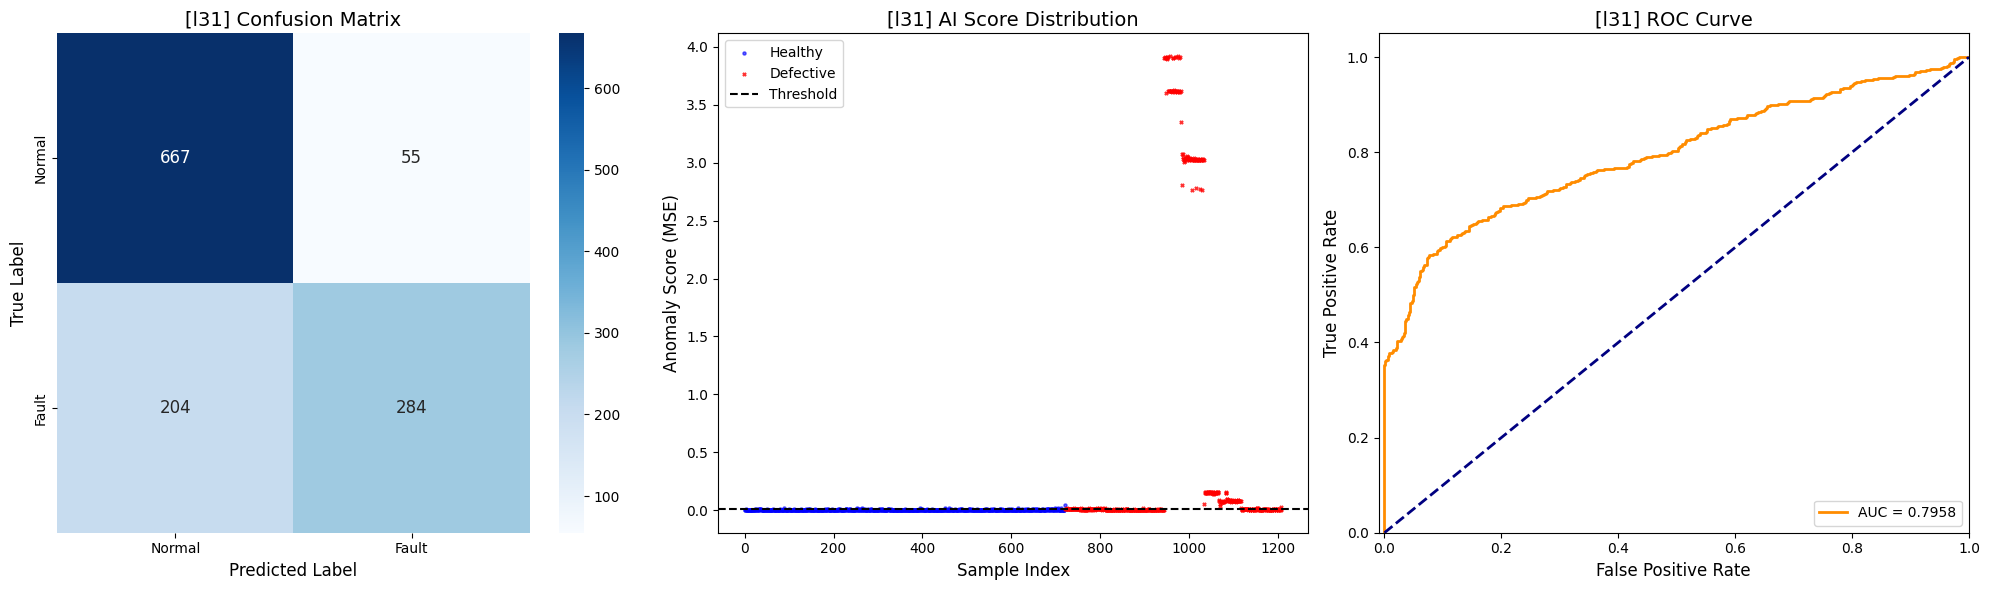

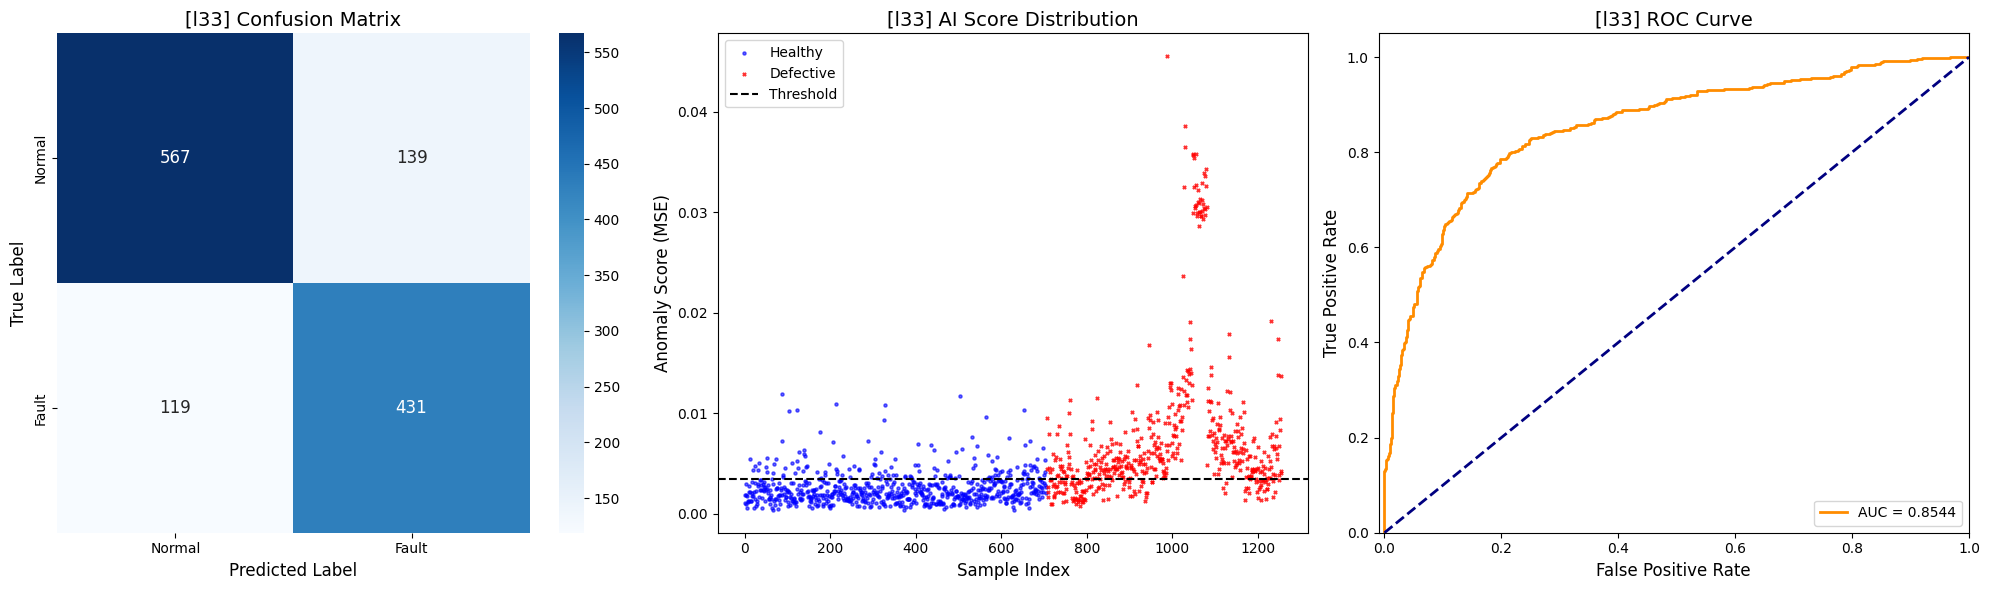

In [ ]:
# 5. 결과 시각화 (수정된 버전)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve

# 그래프 스타일 설정
plt.style.use('default') # 기본 스타일 사용 (흰 배경)

for exp_id, metrics in results.items():
    # 캔버스 생성 (가로로 길게 배치)
    fig = plt.figure(figsize=(20, 6))

    # ---------------------------------------------------------
    # 1. Confusion Matrix (세 번째 이미지 스타일)
    # ---------------------------------------------------------
    ax1 = plt.subplot(1, 3, 1)
    cm = metrics['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fault'],
                yticklabels=['Normal', 'Fault'],
                cbar=True, ax=ax1, annot_kws={"size": 12})

    ax1.set_title(f"[{exp_id}] Confusion Matrix", fontsize=14)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)

    # ---------------------------------------------------------
    # 2. AI Score Distribution (두 번째 이미지 스타일 - Scatter)
    # ---------------------------------------------------------
    ax2 = plt.subplot(1, 3, 2)

    scores_norm = metrics['scores_norm']
    scores_fault = metrics['scores_fault']
    threshold = metrics['threshold']

    # X축 인덱스 생성 (정상 데이터를 먼저 찍고, 그 뒤에 불량 데이터를 이어 붙임)
    norm_idx = np.arange(len(scores_norm))
    fault_idx = np.arange(len(scores_norm), len(scores_norm) + len(scores_fault))

    # 산점도 그리기
    # 정상: 파란색 원
    ax2.scatter(norm_idx, scores_norm, s=5, c='blue', marker='o', label='Healthy', alpha=0.6)
    # 불량: 빨간색 X
    ax2.scatter(fault_idx, scores_fault, s=5, c='red', marker='x', label='Defective', alpha=0.8)

    # 임계값 선 그리기
    ax2.axhline(threshold, color='black', linestyle='--', linewidth=1.5, label='Threshold')

    ax2.set_title(f"[{exp_id}] AI Score Distribution", fontsize=14)
    ax2.set_xlabel('Sample Index', fontsize=12)
    ax2.set_ylabel('Anomaly Score (MSE)', fontsize=12)
    ax2.legend(loc='upper left')

    # (옵션) 점수가 너무 튀어서 정상치가 안 보이면 아래 주석을 해제하여 로그 스케일 적용
    # ax2.set_yscale('log')

    # ---------------------------------------------------------
    # 3. ROC Curve (참조용 유지)
    # ---------------------------------------------------------
    ax3 = plt.subplot(1, 3, 3)

    # 점수와 라벨 합치기
    y_scores = np.concatenate([scores_norm, scores_fault])
    y_true = np.concatenate([np.zeros(len(scores_norm)), np.ones(len(scores_fault))])

    fpr, tpr, _ = roc_curve(y_true, y_scores)

    ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {metrics["auc"]:.4f}')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax3.set_xlim([-0.01, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate', fontsize=12)
    ax3.set_ylabel('True Positive Rate', fontsize=12)
    ax3.set_title(f"[{exp_id}] ROC Curve", fontsize=14)
    ax3.legend(loc="lower right")

    plt.tight_layout()
    plt.show()